In [51]:
import os
import pickle
import pydicom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pydicom.pixel_data_handlers.util import apply_voi_lut
summary_dicom_path = "summary_dicom.pkl"
summary_anot_path = "summary_anot.pkl"


In [2]:
df1 = pd.read_pickle(summary_dicom_path)
df2 = pd.read_pickle(summary_anot_path)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_row', None)


In [3]:
# df2 = df2["seriesuid"].value_counts()
path = []
for key,value in enumerate(df2["seriesuid"]):
    path.append(value)
index = 5
chosen_series_uid = path[index]

In [4]:
df1_ex = df1[df1.SeriesInstanceUID == chosen_series_uid].sort_values(by = ["SliceLocation"])

In [5]:
df1_ex.head()

,StudyInstanceUID,SeriesInstanceUID,SeriesDescription,Rows,Columns,SliceThickness,PixelSpacing,SpacingBetweenSlices,SliceLocation,SmallestImagePixelValue,LargestImagePixelValue,WindowCenter,WindowWidth,ImagePositionPatient,ImageOrientationPatient,RepetitionTime,EchoTime,PatientPosition,NameFileXML
728,1.2.840.113619.6.388.106738880751051415278716030635969460033,1.2.840.113619.2.388.57473.14165493.13177.1591830725.678,GADOLINIUM,256,256,1.4,"[1.0547, 1.0547]",0.700001,-69.7598,0,1514,757,1514,"[-125.509, -136.704, -65.3636]","[0.998067, 0.0523449, 0.0334922, -0.0500444, 0.996552, -0.0661847]",7.208,1.932,HFS,1.2.840.113619.2.388.57473.14165493.11895.1591830765.126.dcm
729,1.2.840.113619.6.388.106738880751051415278716030635969460033,1.2.840.113619.2.388.57473.14165493.13177.1591830725.678,GADOLINIUM,256,256,1.4,"[1.0547, 1.0547]",0.700001,-69.0617,0,1597,798,1597,"[-125.535, -136.659, -64.6655]","[0.998067, 0.0523449, 0.0334922, -0.0500444, 0.996552, -0.0661847]",7.208,1.932,HFS,1.2.840.113619.2.388.57473.14165493.11895.1591830765.127.dcm
730,1.2.840.113619.6.388.106738880751051415278716030635969460033,1.2.840.113619.2.388.57473.14165493.13177.1591830725.678,GADOLINIUM,256,256,1.4,"[1.0547, 1.0547]",0.700001,-68.3637,0,1839,919,1839,"[-125.56, -136.614, -63.9674]","[0.998067, 0.0523449, 0.0334922, -0.0500444, 0.996552, -0.0661847]",7.208,1.932,HFS,1.2.840.113619.2.388.57473.14165493.11895.1591830765.128.dcm
764,1.2.840.113619.6.388.106738880751051415278716030635969460033,1.2.840.113619.2.388.57473.14165493.13177.1591830725.678,GADOLINIUM,256,256,1.4,"[1.0547, 1.0547]",0.700001,-67.6656,0,1980,990,1980,"[-125.586, -136.569, -63.2693]","[0.998067, 0.0523448, 0.0334922, -0.0500444, 0.996552, -0.0661847]",7.208,1.932,HFS,1.2.840.113619.2.388.57473.14165493.11895.1591830765.129.dcm
731,1.2.840.113619.6.388.106738880751051415278716030635969460033,1.2.840.113619.2.388.57473.14165493.13177.1591830725.678,GADOLINIUM,256,256,1.4,"[1.0547, 1.0547]",0.700001,-66.9675,0,2439,1219,2439,"[-125.612, -136.524, -62.5713]","[0.998067, 0.0523449, 0.0334922, -0.0500444, 0.996552, -0.0661847]",7.208,1.932,HFS,1.2.840.113619.2.388.57473.14165493.11895.1591830765.130.dcm


In [6]:
# extract unique z from annotation
points = list(df2[df2.seriesuid == chosen_series_uid]["points"])[0]
z_anot = []
xy3d = []
for point in points:
    z_anot.append(point[2])
z_anot = pd.Series(z_anot).drop_duplicates()
z_anot


0   -15.31380
4    -4.51377
8     9.88623
dtype: float64

In [7]:
z_meta_slice = [float(value) for key,value in enumerate(df1_ex["SliceLocation"])]


In [8]:
z_meta_imgpose = [float(value[2])  for key,value in enumerate(df1_ex["ImagePositionPatient"])]
z_meta_imgpose = sorted(z_meta_imgpose)

In [9]:
# extract slice contain upper, lower and middle annotation point
match_z = []
for z in z_anot:
    print(z)
    abs_store = []
    abs_store = [[index,np.abs(z - z_new)] for index,z_new in enumerate(z_meta_slice) if np.sign(z) == np.sign(z_new)]
    abs_store =  sorted(abs_store, key=lambda x:x[1])
    match_z.append(abs_store[0])
print(match_z)


-15.313799858093
-4.5137701034546
9.88623046875
[[78, 0.0035123780930010895], [93, 0.32544612854540045], [114, 0.06594467174999963]]


In [10]:
xyroot = []

In [11]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

In [12]:
study_uid = "1.2.840.113619.6.388.106738880751051415278716030635969460033"
root = "//media/tungthanhlee/DATA/brain-mri-tumor-dicom-masked"
study_folder = os.path.join(root, study_uid)

extracted_path = []
xyroot = []
for i in match_z:
    print(i[0])
    extracted_path.append( os.path.join(study_folder, df1_ex.iloc[i[0]]["NameFileXML"]))
    xyroot.append(df1_ex.iloc[i[0]]["ImagePositionPatient"])
print(extracted_path)

imgs = []
for i in extracted_path:
    imgs.append(read_xray(i))

78
93
114
['//media/tungthanhlee/DATA/brain-mri-tumor-dicom-masked/1.2.840.113619.6.388.106738880751051415278716030635969460033/1.2.840.113619.2.388.57473.14165493.11895.1591830765.204.dcm', '//media/tungthanhlee/DATA/brain-mri-tumor-dicom-masked/1.2.840.113619.6.388.106738880751051415278716030635969460033/1.2.840.113619.2.388.57473.14165493.11895.1591830765.219.dcm', '//media/tungthanhlee/DATA/brain-mri-tumor-dicom-masked/1.2.840.113619.6.388.106738880751051415278716030635969460033/1.2.840.113619.2.388.57473.14165493.11895.1591830765.240.dcm']


In [14]:
xy3d = [[point[0], point[1]] for point in points]
xy3d

[[-1.3457000255585, -22.289400100708],
 [18.267099380493, -22.289400100708],
 [18.267099380493, -9.8679399490356],
 [-1.3457000255585, -9.8679399490356],
 [-1.3457000255585, -28.1732006073],
 [20.228399276733, -28.1732006073],
 [20.228399276733, -7.2528901100159],
 [-1.3457000255585, -7.2528901100159],
 [6.4994301795959, -23.596900939941],
 [18.267099380493, -23.596900939941],
 [18.267099380493, -9.8679399490356],
 [6.4994301795959, -9.8679399490356]]

In [68]:
pixel_spacing =  float(df1_ex.iloc[0]["PixelSpacing"][0])
delta = np.sqrt(2*((pixel_spacing/2)**2))
print(delta)
xy_root_new = [[float(p[0]) - delta,float(p[1]) + delta] for p in xyroot]
# xy_root_new = [[float(p[0]) ,float(p[1]) ] for p in xyroot]
print(xy_root_new)

0.7457855221174516
[[-128.26578552211745, -132.44321447788255], [-128.65278552211745, -131.76721447788256], [-129.19478552211746, -130.82021447788256]]


In [69]:
xy2d = []
cur_im = []
count1 = 1
count2 = 0
while count1 <  len(xy3d)+1:

    new_p = [xy3d[count1-1][0] - xy_root_new[count2][0],xy3d[count1-1][1] - xy_root_new[count2][1]]
    # xy2d.append(new_p)
    cur_im.append(new_p)
    print(new_p)

    if count1 % 4 == 0:
        xy2d.append(cur_im)
        cur_im = []
        count2 += 1


    count1 += 1
xy2d

[126.92008549655895, 110.15381437717454]
[146.53288490261045, 110.15381437717454]
[146.53288490261045, 122.57527452884695]
[126.92008549655895, 122.57527452884695]
[127.30708549655895, 103.59401387058256]
[148.88118479885046, 103.59401387058256]
[148.88118479885046, 124.51432436786666]
[127.30708549655895, 124.51432436786666]
[135.69421570171335, 107.22331353794155]
[147.46188490261045, 107.22331353794155]
[147.46188490261045, 120.95227452884696]
[135.69421570171335, 120.95227452884696]


[[[126.92008549655895, 110.15381437717454],
  [146.53288490261045, 110.15381437717454],
  [146.53288490261045, 122.57527452884695],
  [126.92008549655895, 122.57527452884695]],
 [[127.30708549655895, 103.59401387058256],
  [148.88118479885046, 103.59401387058256],
  [148.88118479885046, 124.51432436786666],
  [127.30708549655895, 124.51432436786666]],
 [[135.69421570171335, 107.22331353794155],
  [147.46188490261045, 107.22331353794155],
  [147.46188490261045, 120.95227452884696],
  [135.69421570171335, 120.95227452884696]]]

In [70]:
plot_point = []
for cur_im in xy2d:
    x= [ p[0] for p in cur_im]
    print(x)
    y = [ p[1] for p in cur_im ]
    bottomleft = (min(x), min(y))
    height = max(y) - min(y)
    width = max(x) - min(x)
    out = [bottomleft, width, height]
    plot_point.append(out)
plot_point

[126.92008549655895, 146.53288490261045, 146.53288490261045, 126.92008549655895]
[127.30708549655895, 148.88118479885046, 148.88118479885046, 127.30708549655895]
[135.69421570171335, 147.46188490261045, 147.46188490261045, 135.69421570171335]


[[(126.92008549655895, 110.15381437717454),
  19.612799406051494,
  12.421460151672406],
 [(127.30708549655895, 103.59401387058256),
  21.5740993022915,
  20.920310497284106],
 [(135.69421570171335, 107.22331353794155),
  11.767669200897103,
  13.728960990905406]]

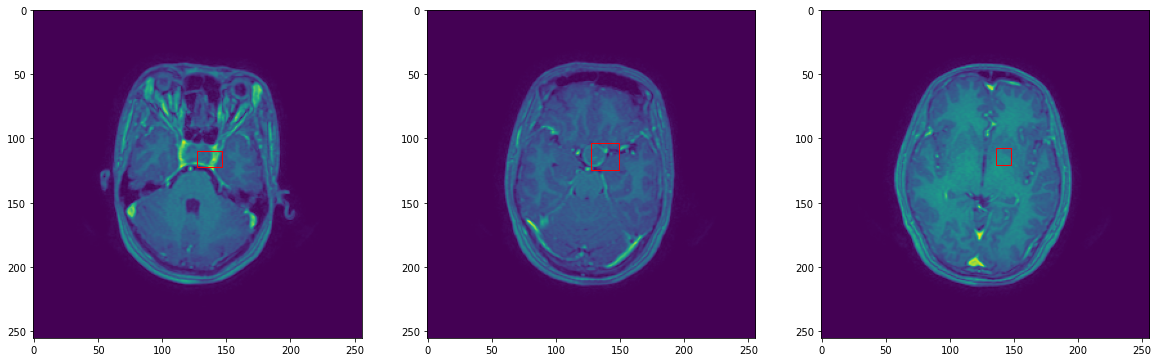

In [72]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(7)
fig.set_figwidth(20)


ax1.imshow(imgs[0])
rect1 = patches.Rectangle(plot_point[0][0], plot_point[0][1], plot_point[0][2], linewidth=1, edgecolor='r', facecolor='none')
ax1.add_patch(rect1)
ax2.imshow(imgs[1])
rect2 = patches.Rectangle(plot_point[1][0], plot_point[1][1], plot_point[1][2], linewidth=1, edgecolor='r', facecolor='none')
ax2.add_patch(rect2)
ax3.imshow(imgs[2])
rect3 = patches.Rectangle(plot_point[2][0], plot_point[2][1], plot_point[2][2], linewidth=1, edgecolor='r', facecolor='none')
ax3.add_patch(rect3)
fig.savefig("check.jpg")